In [4]:
import os
import json
import albumentations as A
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from utils.dataset import load_mask, load_stafflines
from utils.staffline_variations import default_stafflines, staffline_interruptions, thickness_variations, y_variations

DATASET_PATH = os.path.join("..", "..", "datasets", "generated")
PNG_PATH = os.path.join(DATASET_PATH, "png")
BBOX_PATH = os.path.join(DATASET_PATH, "bbox")
OUT_DIR = os.path.join(DATASET_PATH, "aug")

with open(os.path.join(DATASET_PATH, "classlist.json")) as file:
    classlist = json.load(file)
    classmap = {c["id"]:c["class"] for c in classlist}

# Staffline variations

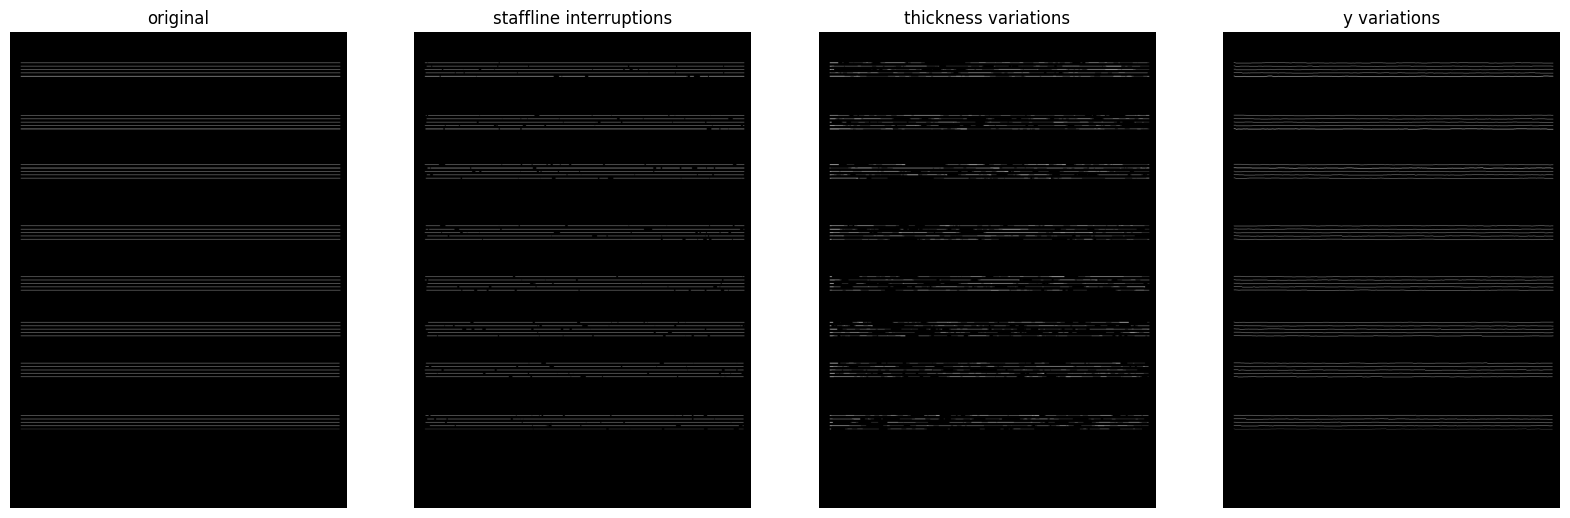

In [5]:
idx = 2
sample_idx = f"{idx:03d}"
staff_mask = load_mask(PNG_PATH, sample_idx, 48)
staff_lines = load_stafflines(PNG_PATH, BBOX_PATH, sample_idx)

def plot_imgs(imgs, titles=None, figsize=(20, 20)):
    n = len(imgs)
    fig, axs = plt.subplots(1, n, figsize=figsize)
    for i in range(n):
        axs[i].imshow(imgs[i], cmap="gray")
        axs[i].axis("off")
        if titles:
            axs[i].set_title(titles[i])

orig = default_stafflines(staff_mask.shape, staff_lines)
aug_01 = staffline_interruptions(staff_mask.shape, staff_lines)
aug_02 = thickness_variations(staff_mask.shape, staff_lines)
aug_03 = y_variations(staff_mask.shape, staff_lines)

plot_imgs([orig, aug_01, aug_02, aug_03], 
          ["original", "staffline interruptions", "thickness variations", "y variations"])

# Mask assembly

In [6]:
order = [
 
 # ensure stafflines first
 46, # Staff
 2, # LedgerLine
 
 # flags underneath stems
 13, # Flag8thUp
 14, # Flag16thUp
 15, # Flag32ndUp
 16, # Flag64thUp
 17, # Flag8thDown
 18, # Flag16thDown
 19, # Flag32ndDown
 20, # Flag64thDown
 12, # Stem
 
 47, # BarLine
 48, # BarLineThick
 
 1, # Brace
 3, # RepeatDot
 4, # ClefG
 5, # ClefF
 6, # TimeSig4
 7, # TimeSigCommon
 11, # AugmentationDot
 
 21, # AccidentalFlat
 22, # AccidentalNatural
 23, # AccidentalSharp
 24, # AccidentalDoubleSharp
 25, # AccidentalDoubleFlat
 
 26, # KeyFlat
 27, # KeyNatural
 28, # KeySharp
 
 29, # RestWhole
 30, # RestHalf
 31, # RestQuarter
 32, # Rest8th
 33, # Rest16th
 34, # Rest32nd
 35, # Rest64th
 36, # DynamicP
 37, # DynamicM
 38, # DynamicF
 39, # Tuplet3
 43, # DynamicCrescendoHairpin
 44, # DynamicDiminuendoHairpin
 45, # TupletBracket
 40, # Slur
 41, # Beam
 42, # Tie
 8, # NoteheadBlack
 9, # NoteheadHalf
 10, # NoteheadWhole
]

Text(0.5, 1.0, 'Sample Assembly')

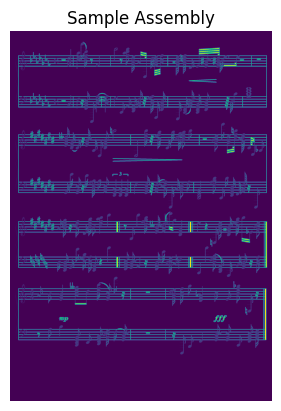

In [7]:
import cv2
import numpy as np

masks = {i-2: load_mask(PNG_PATH, sample_idx, i) for i in range(3, 51)}
comb = np.zeros(masks[1].shape, np.uint8)

for idx in order:
    comb[masks[idx] > 0] = idx
plt.imshow(comb)
plt.axis("off")
plt.title("Sample Assembly")

# Augmentations

In [8]:
augmentations = [
    "ideal",
    "staffline_thickness_variation",
    "staffline_y_variation",
    "staffline_interruptions",
    "dilation_stafflines_k3",
    "dilation_stafflines_k5",
    "dilation_xy_lines_k3",
    "dilation_xy_lines_k5",
    "dilation_all_k3",
    "dilation_all_k5",
]

# make out dirs
for aug in augmentations:
    x_path = os.path.join(OUT_DIR, aug, "x")
    y_path = os.path.join(OUT_DIR, aug, "y")
    os.makedirs(x_path, exist_ok=True)
    os.makedirs(y_path, exist_ok=True)
    
    print(f"augmentation: {aug}")
    
    # iterate over all pages
    for i in tqdm(range(25)):
        
        idx = i + 1
        sample_idx = f"{idx:03d}"
        
        # load masks
        masks = {i-2: load_mask(PNG_PATH, sample_idx, i) for i in range(3, 51)}
        
        # replace staffline mask if necessary
        if aug == "staffline_thickness_variation":
            staff_lines = load_stafflines(PNG_PATH, BBOX_PATH, sample_idx)
            masks[46] = thickness_variations(masks[46].shape, staff_lines)
        if aug == "staffline_y_variation":
            staff_lines = load_stafflines(PNG_PATH, BBOX_PATH, sample_idx)
            masks[46] = y_variations(masks[46].shape, staff_lines)
        if aug == "staffline_interruptions":
            staff_lines = load_stafflines(PNG_PATH, BBOX_PATH, sample_idx)
            masks[46] = staffline_interruptions(masks[46].shape, staff_lines)
        
        # staffline-only dilation
        if aug == "dilation_stafflines_k3" or aug == "dilation_xy_lines_k3":
            kernel = np.ones((3, 3))
            masks[46] = cv2.dilate(masks[46], kernel)
        if aug == "dilation_stafflines_k5" or aug == "dilation_xy_lines_k5":
            kernel = np.ones((5, 5))
            masks[46] = cv2.dilate(masks[46], kernel)
        
        # stem dilation
        if aug == "dilation_xy_lines_k3":
            kernel = np.ones((3, 3))
            masks[12] = cv2.dilate(masks[12], kernel)
        if aug == "dilation_xy_lines_k5":
            kernel = np.ones((5, 5))
            masks[12] = cv2.dilate(masks[12], kernel)

        # all dilation
        if aug == "dilation_all_k3":
            kernel = np.ones((3, 3))
            masks = {idx: cv2.dilate(masks[idx], kernel) for idx in masks}
        if aug == "dilation_all_k5":
            kernel = np.ones((5, 5))
            masks = {idx: cv2.dilate(masks[idx], kernel) for idx in masks}

        # combine masks        
        comb = np.zeros(masks[1].shape, np.uint8)
        for idx in order:
            comb[masks[idx] > 0] = idx
        
        x = np.zeros(masks[1].shape + (1,), np.uint8)
        x[comb>0] = 255
        y = comb
        
        cv2.imwrite(os.path.join(x_path, f"{sample_idx}.png"), x)
        cv2.imwrite(os.path.join(y_path, f"{sample_idx}.png"), y)
print("Done!")

augmentation: ideal


100%|██████████| 25/25 [02:15<00:00,  5.41s/it]


augmentation: staffline_thickness_variation


100%|██████████| 25/25 [04:02<00:00,  9.72s/it]


augmentation: staffline_y_variation


100%|██████████| 25/25 [04:28<00:00, 10.75s/it]


augmentation: staffline_interruptions


100%|██████████| 25/25 [04:27<00:00, 10.68s/it]


augmentation: dilation_stafflines_k3


100%|██████████| 25/25 [02:00<00:00,  4.84s/it]


augmentation: dilation_stafflines_k5


100%|██████████| 25/25 [02:01<00:00,  4.87s/it]


augmentation: dilation_xy_lines_k3


100%|██████████| 25/25 [02:03<00:00,  4.94s/it]


augmentation: dilation_xy_lines_k5


100%|██████████| 25/25 [02:02<00:00,  4.89s/it]


augmentation: dilation_all_k3


100%|██████████| 25/25 [02:06<00:00,  5.05s/it]


augmentation: dilation_all_k5


100%|██████████| 25/25 [02:12<00:00,  5.30s/it]

Done!
